# Tutorial 1 - Reti neurali feedforward in TensorFlow

**Prerequisiti per il tutorial:**
* [T0 - Concetti base di TensorFlow](0-Concetti-base.ipynb)

**Contenuti del tutorial:**
1. Reti neurali feedforward.
2. Implementazione di una rete neurale in TF.
3. Introduzione al modulo <code>contrib.learn</code>.

## Concetti basi delle reti neurali

Dopo aver introdotto i costrutti di base di TF nel primo tutorial, cominciamo ora a vedere come lavorare con le **reti neurali** con due semplici esempi di classificazione. Prima di passare all'implementazione, ricordiamo qualche elemento terminologico essenziale. Una rete neurale artificiale risolve un problema di apprendimento interponendo proiezioni lineari (come nell'esempio della regressione lineare) con funzioni nonlineari:

![Esempio di una rete neurale](images/300px-Colored_neural_network.png) [**Wikipedia**]

Ognuno dei nodi sopra viene detto **neurone**, mentre l'insieme di neuroni dello stesso colore uno **strato**. A causa della sua organizzazione, questo tipo di reti neurali viene detta **feedforward**. Per determinate scelte di funzioni nonlineari, essa rappresenta inoltre un [**approssimatore universale**](https://en.wikipedia.org/wiki/Universal_approximation_theorem), ovvero (informalmente) possiamo rappresentare qualsiasi funzione con un errore piccolo a piacere aumentando in maniera adeguata il numero di neuroni nello strato blu.

Per calcolarne l'uscita, iniziamo calcolando il valore dei neuroni nello strato nascosto (in blu nella figura sopra), dato da:

$$\boldsymbol{h} = g\left(\boldsymbol{W}_1\boldsymbol{x} + \boldsymbol{b}_1\right) \,,$$

dove la matrice $\boldsymbol{W}_1$ ed il vettore $\boldsymbol{b}_1$ vengono adattati durante l'apprendimento, e $g(\cdot)$ rappresenta la funzione nonlineare applicata ad ogni elemento del vettore. Dall'uscita dello strato nascosto possiamo calcolare l'uscita della rete (in verde nella figura sopra) come:

$$f(\boldsymbol{x}) = h\left(\boldsymbol{W}_2\boldsymbol{h} + \boldsymbol{b}_2\right) \,,$$

dove $\boldsymbol{W}_2$ e $\boldsymbol{b}_2$ sono nuovi parametri della rete, e la funzione $h(\cdot)$ è un'altra funzione non-lineare. $g$ ed $h$ vengono dette **funzioni di attivazione**. 

Ovviamente, è immediato inserire più di uno strato nascosto all'interno della rete iterando le equazioni viste prima. Ogni nuovo strato aumenta la capacità espressiva della rete, aumentando similmente il numero di parametri e la quantità di calcoli da eseguire. Per la sua organizzazione, calcolare l'uscita della rete strato per strato viene detto **forward propagation**, mentre calcolare il gradiente di tutti i pesi della rete (partendo dall'uscita) viene detto **back-propagation**. Come detto in precedenza, l'aspetto essenziale di TF è che, una volta definita la rete neurale, la back-propagation viene eseguita in automatico tramite una procedura di differenziazione automatica. 

A livello pratico, una rete neurale si allena con tecniche di ottimizzazione praticamente identiche a quelle introdotte nel primo tutorial, come vedremo tra pochissimo.

## Un dataset di esempio

Come esempio di classificazione binaria carichiamo il dataset delle *due lune* sfruttando una funzione di scikit-learn:

In [1]:
from sklearn import datasets
(X, y) = datasets.make_moons(n_samples=1000)
(X_tst, y_tst) = datasets.make_moons(n_samples=1000)

Abbiamo quindi 1000 esempi per allenare la rete, e 1000 esempi di test per valutarne l'accuratezza. Poiché il dataset è in due sole dimensioni, possiamo visualizzarlo sul piano:

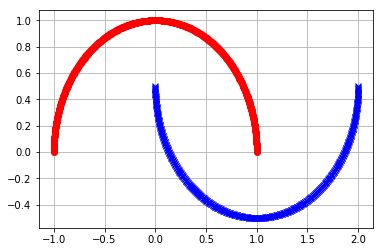

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.plot(X[(y==0), 0], X[(y==0), 1], 'or')
plt.plot(X[(y==1), 0], X[(y==1), 1], 'xb')
plt.grid()

Nonostante la sua semplicità, il dataset è impossibile da separare perfettamente con tecniche lineari. Andiamo quindi a costruire una rete neurale con uno strato nascosto per affrontare il problema.

## Costruire una rete neurale in TF

Cominciamo riportando il nostro output desiderato come valore a virgola mobile invece di intero, per evitare problemi di compatibilità con le operazioni di TF:

In [3]:
import numpy as np
y = y.astype(np.float32).reshape(-1, 1)

Come nell'esempio di regressione lineare, il grafo computazionale inizia dalla definizione di due placeholder corrispondenti al nostro input ed output desiderato:

In [4]:
import tensorflow as tf
X_tf = tf.placeholder(tf.float32, [None, 2])
y_tf = tf.placeholder(tf.float32, [None, 1])

Si noti come in questo caso andiamo a specificare in maniera esplicita le dimensioni delle matrici. Per rendere più realistico l'esempio, nel seguito processeremo il dataset in sotto-blocchi (detti **mini-batch**) di elementi. Per specificare a TF che questi sotto-blocchi potrebbero essere di dimensione variabile, usiamo 'None' come prima dimensione delle matrici.

Definiamo quindi le variabili del nostro strato nascosto, dove per comodità useremo 4 neuroni:

In [5]:
W1 = tf.Variable(np.random.randn(2, 4)*0.01, dtype=tf.float32)
b1 = tf.Variable(np.ones([4])*0.01, dtype=tf.float32)

L'**inizializzazione** di queste variabili è un tema estremamente importante. Per reti relativamente piccole come questa, è comune inizializzare tutti i pesi a piccoli valori estratti da una distribuzione normale, come nel codice sopra. In reti più complesse, un'inizializzazione corretta può invece fare una differenza enorme in termini di velocità di apprendimento (come curiosità, a livello storico le prime applicazioni di deep learning sono derivate proprio da un nuovo modo di inizializzare i pesi anche per reti con molti strati nascosti).

TF mette a disposizione alcune funzioni per inizializzare in modo più furbo i pesi, come la seguente:
https://www.tensorflow.org/api_docs/python/tf/contrib/layers/xavier_initializer

Il modulo <code>contrib</code>, contenente diverse funzioni di interesse come questa, viene introdotto nella prossima sezione.

Costruiamo quindi l'uscita del nostro strato nascosto:

In [6]:
h = tf.nn.tanh(tf.matmul(X_tf, W1) + b1)

La funzione <code>matmul</code> (equivalente a <code>np.linalg.dot</code> in NumPy) esegue la moltiplicazione fra l'input e $\boldsymbol{W}_1$, mentre abbiamo scelto una tangente iperbolica come funzione di attivazione, che ha la seguente forma:

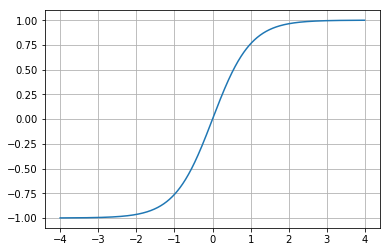

In [7]:
plt.figure()
x_range = np.arange(-4, +4, 0.01)
plt.plot(x_range, np.tanh(x_range))
plt.grid()

Come si può vedere, la funzione è approssimativamente lineare in un breve intervallo, per poi tendere asintoticamente a -1 o +1 al crescere del suo input. Un'altra funzione molto comune per le reti neurali è la cosiddetta **rectified linear unit** (o ReLU):

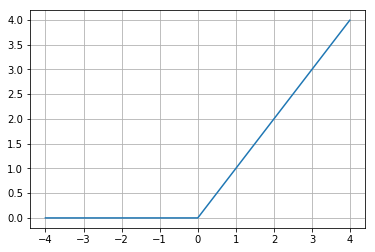

In [8]:
plt.figure()
plt.plot(x_range, np.maximum(0.0, x_range))
plt.grid()

La ReLU ha un gradiente più semplice della tangente iperbolica (in particolare, i suoi valori possono essere solo 0 o 1). Essa introduce inoltre un punto di non-differenziabilità (in 0), ma a livello pratico questo non crea particolari problemi. La ReLU e molte altre varianti si possono trovare nel modulo <code>nn</code> di TF. Continuiamo la costruzione della nostra rete neurale definendo le variabili per lo strato di uscita:

In [9]:
w2 = tf.Variable(np.random.randn(4, 1)*0.01, dtype=tf.float32)
b2 = tf.Variable([0.01], dtype=tf.float32)

Essendo questo un problema di classificazione binaria, come funzione di attivazione in uscita si preferisce una funzione che permetta di ottenere valide probabilità di assegnazione alle classi, come la **sigmoide**:

In [10]:
f = tf.nn.sigmoid(tf.matmul(h, w2) + b2)

Una sigmoide è molto simile alla tangente iperbolica, ma il suo output è sempre limitato fra 0 ed 1:

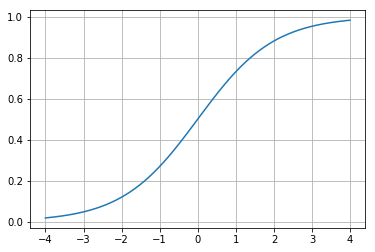

In [11]:
plt.figure()
plt.plot(x_range, 1.0/(1.0 + np.exp(-x_range)))
plt.grid()

In pratica, per definire i vari strati potremmo usare l'interfaccia funzionale definita in <code>layers</code> al posto di definire manualmente le operazioni:
https://www.tensorflow.org/api_docs/python/tf/layers/dense

Vedremo un esempio nel prossimo tutorial.

## Ottimizzazione della rete neurale

Passiamo quindi alla definizione della funzione costo. Nel tutorial precedente abbiamo usato l'errore quadratico. Poiché in questo caso l'uscita dalla rete rappresenta delle probabilità, possiamo usare una funzione di errore più specifica a problemi di classificazione. 

In particolare, una funzione costo molto comune è la cosiddetta **cross-entropia**, definita come segue:

$$- \sum_{i=1}^N y_i\log\left(f(\boldsymbol{x}_i)\right) + (1-y_i)\log\left(1-f(\boldsymbol{x}_i)\right) \,.$$

Per un'introduzione visiva su come si possa derivare questa funzione costo, si rimanda al seguente post (in Inglese):
[Visual Information Theory](https://colah.github.io/posts/2015-09-Visual-Information/).

La sua implementazione in TF è immediata:

In [12]:
loss = - tf.reduce_sum(y_tf*tf.log(f) + (1.0-y_tf)*tf.log(1.0 - f))

In realtà, questa implementazione diretta non è la più vantaggiosa da un punto di vista computazionale. La motivazione è l'interazione del logaritmo (nella definizione della funzione costo) con l'esponenziale presente nella sigmoide, che matematicamente si annullano a vicenda ma vengono entrambi calcolati da TF in questa implementazione. 

TF prevede esplicitamente questo caso, permettendo di definire la cross-entropia direttamente sull'output della rete neurale prima della funzione di attivazione, come segue:

In [13]:
# tf.nn.sigmoid_cross_entropy_with_logits(labels=y_tf, logits=tf.matmul(h, w2) + b2)

Come detto prima, per simulare un caso realistico andiamo ad allenare la rete a partire da mini-batch di elementi di training, in modo da diminuire il costo di eseguire un singolo passo di discesa al gradiente. Per fare questo, definiamo una funzione per estrarre questi mini-batch dall'insieme di training:

In [14]:
def iterate_minibatches(X, y, batchsize):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    for start_idx in range(0, len(X) - batchsize + 1, batchsize):
        excerpt = indices[start_idx:start_idx + batchsize]
        yield X[excerpt], y[excerpt]

La funzione (adattata dal repository di [Lasagne](https://github.com/Lasagne/Lasagne/blob/master/examples/mnist.py)) permette di iterare sul training set ritornando gruppi di elementi di dimensione <code>batchsize</code>, il cui valore è a scelta dell'utente. Si noti come i dati vengono mescolati prima di ogni chiamata alla funzione.

Come algoritmo di ottimizzazione, usiamo qualcosa di più evoluto di una discesa al gradiente classica, ovvero una discesa al gradiente con **momentum** (*inerzia* in Italiano):

In [15]:
train_step = tf.train.MomentumOptimizer(learning_rate=0.01, momentum=0.9).minimize(loss)

A differenza della discesa al gradiente classico, in questo caso il passo di discesa viene ottenuto combinando il passo standard con il passo all'istante precedente. Per un'introduzione, si vedano i grafici interattivi al seguente link:

[Goh, "Why Momentum Really Works", Distill, 2017. http://doi.org/10.23915/distill.00006](http://distill.pub/2017/momentum/)

Inoltre, a differenza dello scorso tutorial, per eseguire il grafo computazionale useremo una sessione interattiva. L'unica differenza con una sessione classica è che una sessione interattiva si registra automaticamente come sessione di default, permettendo in seguito di eseguire i comandi di TF senza specificare la sessione in uso:

In [16]:
sess = tf.InteractiveSession()

Inizializziamo tutte le variabili del grafo:

In [17]:
tf.global_variables_initializer().run()

Si noti come, con una sessione normale, avremmo dovuto passare la sessione stessa come parametro del metodo <code>run</code>. Definiamo quindi la dimensione dei nostri mini-batch, ed il numero di epoche (passaggi sul training set) per l'ottimizzazione:

In [18]:
epochs = 200
batch_size = 10

L'ottimizzazione è uguale al tutorial sulla regressione lineare, con la differenza che ad ogni iterazione eseguiamo un loop sui mini-batch estratti dal training set, ed usiamo quelli per l'ottimizzazione:

In [19]:
loss_history = np.zeros(epochs)
for i in range(epochs):
    loss_history[i] = sess.run(loss, feed_dict={X_tf: X, y_tf: y})
    for xs, ys in iterate_minibatches(X, y, batch_size):
        sess.run(train_step, feed_dict={X_tf: xs, y_tf: ys})

Possiamo vedere l'evoluzione della funzione costo per assicurarci del buon comportamento dell'algoritmo di ottimizzazione:

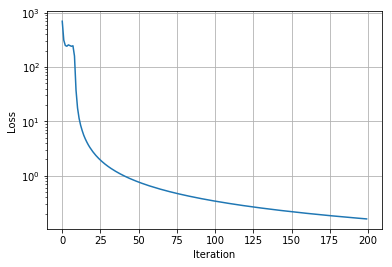

In [20]:
plt.figure()
plt.semilogy(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid()

Calcoliamo l'accuratezza del modello sui dati di test, ricordandoci di arrotondare le uscite (reali) della rete neurale per ottenere solamente $0$ od $1$:

In [21]:
from sklearn import metrics
y_pred = np.round(sess.run(f, feed_dict={X_tf: X_tst}))
print('Final accuracy is: ', metrics.accuracy_score(y_tst, y_pred))

Final accuracy is:  1.0


Essendo l'esempio molto semplice, la rete raggiunge un'accuratezza del 100% senza necessità di regolarizzazione. Per concludere questo esempio, andiamo a visualizzare la regione di decisione della rete neurale. Creiamo una griglia di punti equamente spaziati sul piano con risoluzione 0.1:

In [22]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Calcoliamo l'uscita della rete neurale su tutti i punti della griglia:

In [23]:
Z = sess.run(f, feed_dict={X_tf:np.c_[xx.ravel(), yy.ravel()]}) 

Infine, visualizziamo la regione:

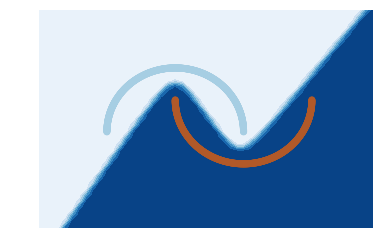

In [24]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues)
plt.axis('off')

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.show()

## Allenare reti neurali con contrib.learn

Come abbiamo visto, allenare reti neurali in TF è molto semplice, ma definirne la struttura e gestire i dati di training è più convoluto. A questo scopo, sono nate nel tempo numerose API ad alto livello che permettono di lavorare in TF in maniera più astratta e generale, permettendo rapidamente la prototipazione di una rete neurale. 

La più famosa di queste, [Keras](https://keras.io/), nasce al di fuori di TF prima di esserne inglobata nelle ultime versioni, e la introdurremo nel prossimo tutorial. Qui ci interessiamo ad un'alternativa, nata all'interno di TF nel modulo <code>contrib.learn</code>. Tutti i moduli all'interno di <code>contrib</code> rappresentano codice più sperimentale (ed in evoluzione), che nei prossimi mesi sarà spostato in modo definitivo nell'API stabile di TF oppure verrà modificato/abbandonato. Tra tutti i moduli presenti, <code>learn</code> rappresenta un'interfaccia ad alto livello per definire **stimatori** da usare in applicazioni di machine learning. Possiamo pensare a <code>contrib.learn</code> come all'equivalente di scikit-learn all'interno di TF.

Per questo tutorial, replichiamo l'esempio presente sulla documentazione ufficiale di TF:
https://www.tensorflow.org/get_started/tflearn.

Come dataset usiamo **Iris**, un dataset storico di classificazione, dove il compito è predire la classe di Iris (fra tre possibilità) a partire da quattro misure fisiche. Iniziamo scaricando il dataset di training dal seguente link:

http://download.tensorflow.org/data/iris_training.csv

Possiamo caricare il dataset con una funzione di contrib.learn come segue (ricordatevi di cambiare il percorso):

In [25]:
training_set = tf.contrib.learn.datasets.base.load_csv_with_header(
      filename='../../../Downloads/iris_training.csv',
      target_dtype=np.int,
      features_dtype=np.float32)

In contrib.learn è possibile associare a ciascuna feature un tipo ed un nome, potendo quindi mischiare feature reali, sparse, categoriche, e così via. Nel nostro caso, abbiamo solo 4 feature, tutte continue, a cui non associamo un nome: 

In [26]:
# Sepal Length, Sepal Width, Petal Length and Petal Width
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=4)]

Andiamo quindi a creare una rete neurale con due strati nascosti, di 10 neuroni ciascuno:

In [27]:
classifier_nn = tf.contrib.learn.DNNClassifier(feature_columns=feature_columns,
                                              hidden_units=[10, 10],
                                              n_classes=3,
                                              model_dir="tmp/iris_model_nn/")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_keep_checkpoint_max': 5, '_save_checkpoints_steps': None, '_evaluation_master': '', '_save_summary_steps': 100, '_num_ps_replicas': 0, '_tf_random_seed': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_every_n_hours': 10000, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000000000BE19EB8>, '_environment': 'local', '_master': '', '_is_chief': True, '_task_id': 0}


I modelli presenti in contrib.learn non si limitano a reti neurali, ma includono anche modelli lineari, SVM, algoritmi di clustering, e così via. Ad esempio, possiamo definire un classificatore lineare come segue:

In [28]:
classifier_linear = tf.contrib.learn.LinearClassifier(feature_columns=feature_columns,
                                              n_classes=3,
                                              model_dir="tmp/iris_model_linear/")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_keep_checkpoint_max': 5, '_save_checkpoints_steps': None, '_evaluation_master': '', '_save_summary_steps': 100, '_num_ps_replicas': 0, '_tf_random_seed': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_every_n_hours': 10000, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000000000BDE5F28>, '_environment': 'local', '_master': '', '_is_chief': True, '_task_id': 0}


Come si vede, il modulo è preconfigurato per mostrare numerose informazioni in output. Per non occludere il notebook, limitiamo la visualizzazione ai soli errori critici:

In [29]:
tf.logging.set_verbosity(tf.logging.FATAL)

Il training di uno stimatore in contrib.learn avviene definendo una funzione di input che si occupi di caricare i dati, preprocessarli, e così via. I dati in output devono essere costanti di TF, come nella funzione che segue:

In [30]:
def get_train_inputs():
    x = tf.constant(training_set.data)
    y = tf.constant(training_set.target)

    return x, y

Nel caso in cui le feature non siano tutte continue, l'input restituito dalla funzione sarà un dizionario che associa, a ciascuna feature, la colonna corrispondente del tipo adeguato. Per allenare i classificatori il modulo mette a disposizione una funzione <code>fit</code>, come in scikit-learn:

In [31]:
# Allenamento del modello
classifier_nn.fit(input_fn=get_train_inputs, steps=1000)

DNNClassifier(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._MultiClassHead object at 0x000000000BDF3898>, 'activation_fn': <function relu at 0x000000000A5617B8>, 'input_layer_min_slice_size': None, 'feature_columns': (_RealValuedColumn(column_name='', dimension=4, default_value=None, dtype=tf.float32, normalizer=None),), 'optimizer': None, 'hidden_units': [10, 10], 'gradient_clip_norm': None, 'embedding_lr_multipliers': None, 'dropout': None})

Per testare i modelli, scarichiamo il dataset di test dal seguente link:

http://download.tensorflow.org/data/iris_test.csv

Possiamo quindi caricarlo come prima:

In [32]:
test_set = tf.contrib.learn.datasets.base.load_csv_with_header(
      filename='../../../Downloads/iris_test.csv',
      target_dtype=np.int,
      features_dtype=np.float32)

Definiamo una funzione per caricare i dati di test:

In [33]:
def get_test_inputs():
    x = tf.constant(test_set.data)
    y = tf.constant(test_set.target)

    return x, y

Infine, sfruttiamo le funzioni messe a disposizione da contrib.learn per valuturare i modelli:

In [34]:
# Evaluate accuracy
accuracy_score_nn = classifier_nn.evaluate(input_fn=get_test_inputs,
                                     steps=1)["accuracy"]

print("\nTest Accuracy: {0:f}".format(accuracy_score_nn))


Test Accuracy: 0.966667


contrib.learn è, ovviamente, molto più complesso di quanto visto in questo tutorial, permettendo il training in parallelo a partire da grandi moli di dati, operazioni di checkpoint sui modelli, e così via. Vedremo alcune di queste funzionalità più avanzate in un tutorial più avanti. Per ora, continuiamo la nostra esplorazione di TF introducendo altri tipi di reti neurali, più adatte a processare immagini (**reti convolutive**) o sequenze (**reti ricorrenti**).